http://export.finam.ru/MICEX.csv?market=0&em=420450&code=MICEX&df=10&mf=9&yf=2021&from=2021-10-10+16%3A13%3A55.178415&dt=9&mt=10&yt=2021&to=2021-11-09+16%3A13%3A55.178415&p=6&f=MICEX&e=.csv&cn=MICEX&dtf=1&MSOR=0&mstime=on&mstimever=1&sep=1&sep2=1&datf=1&at=1


C:\Users\sem\AppData\Local\Temp/ipykernel_16108/1165709314.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(dates)


UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 93: character maps to <undefined>

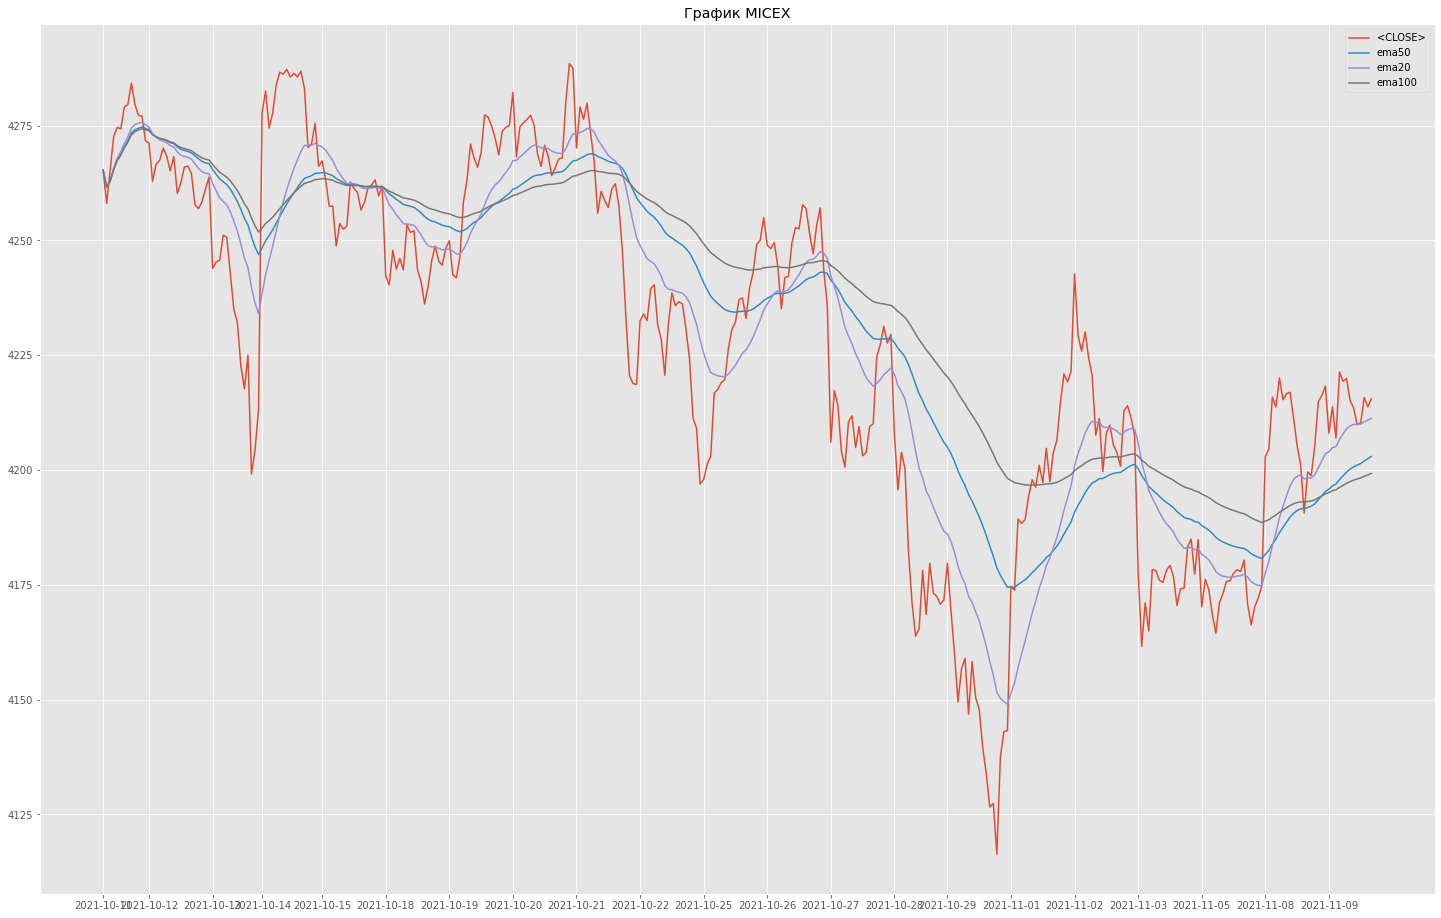

In [1]:
import difflib
import re
import time
from glob import glob
import os
import matplotlib.pyplot as plt
from textwrap import wrap
from miner import *

#В папке path должны лежать все файлы с рекомендациями от Романа Андреева (и не только) по датам
#в файлах с именами ГГГГММДД.txt в обычном текстовом формате, например '20201103.txt'
path = 'RomanAndreev/'

#------------------кусок файла приведен ниже:-------------------------------------------------------
#Вчера индекс ММВБ закрыл день белой свечкой. Отбившись вниз от низа своего осн канала (на утро 2686)
#он выполнил свою первую цель в лице низа более локального канала (на утро 2660), проколов уровень на
#...
#СиПи подрастает и должен потестить свои сопротивления (на утро — зона 3333-3336): отбой оттуда продаем
#с целями 3232, 3168 и 3106, пробой с ретестом покупаем с целями 3402 и 3420. Закрепимся выше 3420  — обновим истхаи.
#
#Евро-доллар застопорил свое снижение и может потестить снизу пробитые поддержки (на утро 1,1713 и 1,1744):
#отбой оттуда или пробой недавнего лоя продаем до зоны 1,1535-1,1502, пробой с ретестом снова покупаем до 1,1942 и 1,2152.
#...

#Список инструментов, которые анализирует Роман. Тикер - токен: тикер это торгуемый актив, а токен - его привычное название.
# Ключ в словаре tickers ДОЛЖЕН СТРОГО СООТВЕТСТВОВАТЬ ключу в словаре symbols (в модуле загрузки котировок с Финама)
tickers = {'MICEX' : 'ММВБ',
           'GD' : 'Золото',
           'S&P' : 'СиПи',
           'BZ' : 'Нефть',
           'ED' : 'Евро-доллар',
           'USDRUB' : 'Доллар-рубль'}

######################## Помощники при семантическом;) разборе предложения для поиска ценовых уровней ####################
skip_nums = ["1", "2", "3", "4", "5"] #Эти числа мы исключаем из анализа, если только цена актива не находится рядом с ними

#Функция, определяющаа похожесть строк s1 и s2. Чем болше строки похожи друг на друга тем значение будет ближе к 1, иначе к 0
def similarity(s1, s2):
    matcher = difflib.SequenceMatcher(None, s1.lower(), s2.lower())
    return matcher.ratio()

#Функция, вернет тикер из списка tickers, если в строке text, в первых четырех словах встречается близкое совпадение
#с названием тикера, иначе возвращает False. Т.е. определяет о каком тикере в предложении идет речь.
def what_ticker_about (text):
    words4 = re.split(' ', text, maxsplit=4)[:4]
    for ticker in tickers:
        if max(map(lambda w: similarity(w, tickers[ticker]), words4)) > 0.67:
            return ticker
    return False

#Функция находит в предложении sentence все значимые числа, которые, как мы считаем, могут представлять ценовые уровни,
# при этом исключая часто встречаемые числа, например "1-я волна", "2 раза" и т.д. Заодно меняем в числовых значениях
# запятые на точки и возвращаем список значений в формате float.
def find_levels (sentence):
    levels = re.findall(r'\d+\,\d+|\d+', sentence)
    levels_str = [level for level in levels if level not in skip_nums]
    return list(map(lambda x: float(x.replace(",", ".")), levels_str))

#Определяет диапазоны цен, возвращает список пар (нижняя-верхняя границы диапазона): [['38.5', '38.65'], ['40.25', '40.38']]
def find_zones (sentence):
    zones = re.findall(r'\d+\-\d+|\d+\,\d+\-\d+\,\d+', sentence)
    return list(map(lambda x: x.replace(",", ".").split('-'), zones))

#################################### Помощники для построения графиков ##########################################
#Определяет начальную и конечную позицию Х (по индексу свечей) для заданной даты. Пригодится при отрисовке ценовых уровней
def DateX (date, candles):
    #Цикл по датам в свечах, результат - список X-координат, соответствующих заданной дате
    xpositions = [index for index, row in candles.iterrows() if row['DT'].date() == date]
    #Возвращает список - пару начальная координата Х и конечная координата Х для заданной даты на графике
    if xpositions == []:
        return [len(candles)-1, len(candles)] #На случай если за текущую дату нет еще свечей
    return [xpositions[0], xpositions[-1]]

#Рисует метки дат на оси Х
def PlotDatesX (fig, candles):
    #Составляем список дат (только уникальные даты) из столбца DT. Они будут метками на оси Х. Сортировка по датам
    #обязательна, т.к. при создании множества(set) даже из отсортированного списка, множество может не сохранить порядок списка
    dates = sorted(set(map(lambda dt: datetime.date(dt), candles['DT'])))
    #Создаем список координат Х для каждой метки (даты). Нам нужна только первая позиция - [0].
    xlabel = [DateX(d, candles)[0] for d in dates]
    #Рисуем ось Х, разделенную по датам
    fig.set_xticklabels(dates)
    fig.set_xticks(xlabel)
    return dates, xlabel

#Рисует основной график
def draw_candles(candles):
    #Добавим на график несколько ЕМА-средних
    candles['ema100'] = pd.Series.ewm(candles['<CLOSE>'], span=100).mean()
    candles['ema50'] = pd.Series.ewm(candles['<CLOSE>'], span=50).mean()
    candles['ema20'] = pd.Series.ewm(candles['<CLOSE>'], span=20).mean()
    plt.style.use('ggplot') #'seaborn-paper'
    #Отображаем график по цене закрытия свечей и ЕМА-шки
    fig = candles.plot(y=['<CLOSE>', 'ema50', 'ema20', 'ema100'], figsize=(25,16))
    #Добавляем заголовок
    fig.set_title('График ' + candles['<TICKER>'][0])
    #Рисуем шкалу с датами
    PlotDatesX (fig, candles)

#Рисует горизонтальные уровни цен на основном графике, соответствующие уровням рекомендаций на заданную дату
def draw_levels (datetime_date, candles, levels):
    for level in levels:
        #Левая и правая Х-координата для даты на графике [x1, x2]
        DX = DateX(datetime_date, candles)
        plt.plot(DX, [level, level], color = 'dimgray', linewidth = 0.8)

#Рисуем зоны на основном графике, соответствующие диапазонам рекомендаций на заданную дату
def draw_zones (datetime_date, candles, zones):
    for zone in zones:
        #Левая и правая Х-координата для даты на графике [x1, x2]
        DX = DateX(datetime_date, candles)
        plt.fill([DX[0], DX[0], DX[1], DX[1]], [float(zone[0]), float(zone[1]), float(zone[1]), float(zone[0])], alpha = 0.3)

#Функция завершает отрисовку "сегодняшних" ценовых уровней, подписывая их значения, а также располагает текст
#рекомендации на графике. На вход принимает свечи, уровни и текст рекомендации advice
def sign_levels (candles, levels, advice):
    x = len(candles) #Координата Х правого края графика
    for level in levels:
        plt.text(x+3, level, str(level), color = 'white', verticalalignment='center', bbox={'facecolor': 'dimgray', 'pad': 2})
    price = candles.iloc[-1]['<CLOSE>']
    plt.text(x+3, price, str(price), color = 'white', verticalalignment='center', bbox={'facecolor': 'orange', 'pad': 2})
    #Пытаемся красиво разместить текст рекомендации. Разобьем ее (рекомендацию) на строчки по 98 символов
    wrapped = '\n'.join(wrap(advice, width=98))
    #Сам текст рекомендации разместим на минимальном по значению уровне и в левой части графика
    text_ypos = min(levels)
    plt.text(3, text_ypos, wrapped, fontsize=15, color='dimgray', bbox={'facecolor': 'white', 'alpha': 0,'pad': 2})

#Основная функция для запуска. В папке path должны лежать все файлы с рекомендациями от Романа Андреева (и не только)
#по датам в файлах с именами ГГГГММДД.txt в обычном текстовом формате
def start_function(path):
    days_with_levels = 7 #за какое количество дней назад от сегодняшнего показывать уровни рекомендаций
    days_for_chart = 30 #за какое количество дней строить общий график
    time_frame = '30min' #какой тайм-фрейм использовать для графика
    #Проход по всем тикерам в списке рекомендаций
    for ticker in tickers:
        last_levels = [] #в этой переменной после окончания цикла будут уровни текущего дня, которые мы подпишем на графике
        last_advice = '' #а в этой переменной рекомендации на текущий день
        #Читаем в датафрейм candles свечки с сайта Финама
        candles = GetCandles (ticker, time_frame, days_for_chart)
        time.sleep(0.5) #делаем небольшую задержку в запросах к серверу котировок, чтобы нас Финам не забанил
        draw_candles(candles)
        #В этой папке path должны лежать все файлы с рекомендациями от Романа Андреева по датам в формате ГГГГММДД.txt
        # for file in sorted(glob(f'{path}\\*.txt'))[-days_with_levels:]:
        for file in sorted(glob(os.path.join(path, '*.txt')))[-days_with_levels:]:
            with open(file, 'r') as f:
                current_date = os.path.splitext(os.path.basename(file))[0]
                #Читаем файл по абзацам, исключая пустые строки
                indent = [line.strip() for line in f if line.strip()]
                #Разбираем абзац на предложения
                for sentence in indent:
                    #Если находим упоминание тикера в предложениях абзаца
                    found_ticker = what_ticker_about(sentence)
                    if found_ticker == ticker:
                        #Определяем уровни цен для тикера за эту дату
                        levels = find_levels(sentence)
                        zones = find_zones(sentence)
                        last_levels = levels
                        last_advice = sentence
                        print ("Proceccing...", current_date, ticker)
                        draw_levels(ToDate(current_date), candles, levels)
                        draw_zones(ToDate(current_date), candles, zones)
        #Подписываем уровни "свежих" (сегодняшних) рекомендаций
        #sign_levels(candles, last_levels, last_advice)

#Запуск!
path_ = 'Comments/'
start_function(path_)